## Sentiment analysis project

This is a simple sentiment analysis project with standard ML models and RNN. Data was taken from [kaggle](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import os
import random
import random as python_random
import tensorflow as tf
from tensorflow import keras


os.environ['PYTHONHASHSEED'] = '200'
python_random.seed(200)
np.random.seed(200)
tf.random.set_seed(200)

Lets first load our data and see how it looks like.

In [5]:
df = pd.read_csv('all-data.csv', engine='python')

In [6]:
df.head(5)

,sentiment,review
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


We have 3 different classes to predict and the dataset is imbalanced as it is shown below.

In [7]:
np.round(df['sentiment'].value_counts() * 100 / len(df), 2)

neutral     59.41
positive    28.13
negative    12.46
Name: sentiment, dtype: float64

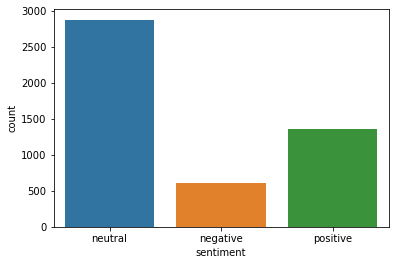

In [8]:
sns.countplot(data=df, x=df['sentiment'])

Every review has to be preprocessed in some way before training. First we will clean all the texts using *regular expressions*. Then we will remove *stopwords* and use either a *stemmer* or a *lemmatizer*. The next step will be to encode reviews in some way. For the ML models I will use a *Tfidf* vectorizer and for the RNN a *TextVectorization* layer followed by an *Embedding* layer.

Below we can see that our reviews contain lots of numbers, prices, dates and symbols. Using regular expressions we can replace some patterns with the other. For this purpose we can define a function which will do the required replacements and then wrap it as a transfomer so that it can be saved for future preprocessing on the new instances.

In [9]:
list(df['review'])[:10]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .',
 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .',
 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
 "According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",
 "FINANCING OF ASPOCO

Before writing the function lets also split the data for features and targets with encoded labels.

In [10]:
classes_map = {'neutral': 0, 'positive': 1, 'negative': 2}
df['sentiment'] = df['sentiment'].map(classes_map)
X = df['review'].copy()
y = df['sentiment'].copy()

In [11]:
def apply_regex(X):
    # replace any urls with "url"
    X = [re.sub(r'http\S+', ' url', r) for r in X]
    
    # replace any breakline and carriage return patterns with a space
    X = [re.sub('[\n\r]', ' ', r) for r in X]
    
    # replace dates in the format day.month.year with a "date"
    X = [re.sub('([0-2][0-9]|(3)[0-1])\.(((0)[0-9])|((1)[0-2]))\.\d{2,4}', ' date ', r) for r in X]
    
    # replace year with a "year"
    X = [re.sub(r'\d{4}', 'year', r) for r in X]
    
    # replace %, $ and US$ patterns
    X = [re.sub('[%]', 'percent', r) for r in X]
    X = [re.sub('US\$', 'USD', r) for r in X]
    X = [re.sub('[$]', 'USD', r) for r in X]
    
    # replace any non word strings with a space
    X = [re.sub('\W', ' ', r) for r in X]

    # remove additional whitespaces
    X = [re.sub('\s+', ' ', r) for r in X]
    X = [re.sub('[ \t]+$', '', r) for r in X]
    
    return X

In [12]:
apply_regex_tf = FunctionTransformer(apply_regex)

The next step is to remove stopwords from every review. To do this we first have to get the list of stopwords in english language and then write a simple function which can be again wrapped as a transformer.

In [13]:
eng_stopwords = stopwords.words('english')

In [14]:
def stopwords_removal(X, cached_stopwords=eng_stopwords):
    words = [[c.lower() for c in text.split() if c.lower() not in cached_stopwords] for text in X]
    return [' '.join(i) for i in words]

In [15]:
stopwords_remover_tf = FunctionTransformer(stopwords_removal, kw_args={'cached_stopwords':eng_stopwords})

In [16]:
X_reg_stop = apply_regex_tf.fit_transform(X)

In [17]:
X_reg_stop[:10]

['According to Gran the company has no plans to move all production to Russia although that is where the company is growing',
 'Technopolis plans to develop in stages an area of no less than 100 000 square meters in order to host companies working in computer technologies and telecommunications the statement said',
 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility contrary to earlier layoffs the company contracted the ranks of its office workers the daily Postimees reported',
 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability',
 'According to the company s updated strategy for the years year year Basware targets a long term net sales growth in the range of 20 percent 40 percent with an operating profit margin of 10 percent 20 percent of net sales',
 'FINANCING OF ASPOCOM

## Standard ML models - lemmatization

Now we can either use lemmatization or stemming. Lets start with the first one. For this purpose we can use a *WordNetLemmatizer*. One has to specify the context in which every word should be lemmatized. Here we choose *verb*. Entire process is wrapped in the small function below. 

In [450]:
def lemmatization_process(X, lemmatizer=WordNetLemmatizer()):
    words = [[lemmatizer.lemmatize(c, pos='v') for c in text.split()] for text in X]
    return [' '.join(i) for i in words]

In [451]:
lemmatization_process_tf = FunctionTransformer(lemmatization_process, kw_args={'lemmatizer':WordNetLemmatizer()})

All 3 preprocessing steps were wrapped as the transformers and now we can simply put them all together and create a single preprocessing pipeline. The last step in the pipeline will be a *Tfidf* vectorization. Each review is encoded as a vector with the length of the vocabulary (automatically created) and for each word which is present in the review we get a score. This score is a ratio of the *term frequency* to the *inverse document frequency*. Term frequency -> how many times word occured in the review / total number of words in the review. Inverse document frequency -> total number of documents / number of documents in which this specific word occured. 

In [466]:
text_prep_pipeline = Pipeline([
    ('regex', apply_regex_tf),
    ('stopwords', stopwords_remover_tf),
    ('lemmatization', lemmatization_process_tf),
    ('vectorizer', TfidfVectorizer(stop_words=eng_stopwords))
])

In [467]:
X_prep = text_prep_pipeline.fit_transform(X)

In [468]:
X_prep

<4846x8494 sparse matrix of type '<class 'numpy.float64'>'
	with 60165 stored elements in Compressed Sparse Row format>

In [469]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, stratify=y, random_state=200)

We will try couple of models to see what performance we can get.

In [471]:
models = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(n_jobs=-1),
    'knc': KNeighborsClassifier(n_jobs=-1),
    'svc': SVC(),
    'xgb': XGBClassifier(n_jobs=-1),
    'cat': CatBoostClassifier(),
    'extra': ExtraTreesClassifier(n_jobs=-1),
}

trained_models = {}

for name, algo in models.items():
    model = algo.fit(X_train, y_train)
    trained_models[name] = model

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.084787
0:	learn: 1.0566923	total: 112ms	remaining: 1m 52s
1:	learn: 1.0267853	total: 175ms	remaining: 1m 27s
2:	learn: 0.9996117	total: 238ms	remaining: 1m 19s
3:	learn: 0.9802544	total: 302ms	remaining: 1m 15s
4:	learn: 0.9601368	total: 365ms	remaining: 1m 12s
5:	learn: 0.9432358	total: 432ms	remaining: 1m 11s
6:	learn: 0.9275209	total: 495ms	remaining: 1m 10s
7:	learn: 0.9141004	total: 555ms	remaining: 1m 8s
8:	learn: 0.9018989	total: 621ms	remaining: 1m 8s
9:	learn: 0.8907620	total: 686ms	remaining: 1m 7s
10:	learn: 0.8798963	total: 750ms	remaining: 1m 7s
11:	learn: 0.8689757	total: 815ms	remaining: 1m 7s
12:	learn: 0.8599072	total: 873ms	remaining: 1m 6s

157:	learn: 0.6307297	total: 9.7s	remaining: 51.7s
158:	learn: 0.6298473	total: 9.76s	remaining: 51.6s
159:	learn: 0.6292683	total: 9.82s	remaining: 51.6s
160:	learn: 0.6285712	total: 9.88s	remaining: 51.5s
161:	learn: 0.6278273	total: 9.94s	remaining: 51.4s
162:	learn: 0.6267085	total: 10s	remaining: 51.3s
163:	learn: 0.6261216	total: 10.1s	remaining: 51.2s
164:	learn: 0.6255146	total: 10.1s	remaining: 51.2s
165:	learn: 0.6248523	total: 10.2s	remaining: 51.1s
166:	learn: 0.6240877	total: 10.2s	remaining: 51s
167:	learn: 0.6238028	total: 10.3s	remaining: 50.9s
168:	learn: 0.6231187	total: 10.3s	remaining: 50.9s
169:	learn: 0.6225154	total: 10.4s	remaining: 50.8s
170:	learn: 0.6218299	total: 10.5s	remaining: 50.7s
171:	learn: 0.6212715	total: 10.5s	remaining: 50.6s
172:	learn: 0.6205646	total: 10.6s	remaining: 50.6s
173:	learn: 0.6197029	total: 10.6s	remaining: 50.5s
174:	learn: 0.6191496	total: 10.7s	remaining: 50.4s
175:	learn: 0.6186577	total: 10.8s	remaining: 50.3s
176:	learn: 0.618

319:	learn: 0.5596418	total: 19.1s	remaining: 40.5s
320:	learn: 0.5592311	total: 19.1s	remaining: 40.5s
321:	learn: 0.5590239	total: 19.2s	remaining: 40.4s
322:	learn: 0.5588364	total: 19.3s	remaining: 40.4s
323:	learn: 0.5584249	total: 19.3s	remaining: 40.3s
324:	learn: 0.5579454	total: 19.4s	remaining: 40.2s
325:	learn: 0.5576495	total: 19.4s	remaining: 40.2s
326:	learn: 0.5573459	total: 19.5s	remaining: 40.1s
327:	learn: 0.5570990	total: 19.5s	remaining: 40s
328:	learn: 0.5567952	total: 19.6s	remaining: 40s
329:	learn: 0.5565027	total: 19.7s	remaining: 39.9s
330:	learn: 0.5562817	total: 19.7s	remaining: 39.8s
331:	learn: 0.5559017	total: 19.8s	remaining: 39.8s
332:	learn: 0.5556852	total: 19.8s	remaining: 39.7s
333:	learn: 0.5553941	total: 19.9s	remaining: 39.7s
334:	learn: 0.5551721	total: 19.9s	remaining: 39.6s
335:	learn: 0.5550187	total: 20s	remaining: 39.5s
336:	learn: 0.5547896	total: 20.1s	remaining: 39.5s
337:	learn: 0.5545080	total: 20.1s	remaining: 39.4s
338:	learn: 0.5543

478:	learn: 0.5218752	total: 28.3s	remaining: 30.8s
479:	learn: 0.5217087	total: 28.4s	remaining: 30.7s
480:	learn: 0.5215679	total: 28.4s	remaining: 30.7s
481:	learn: 0.5214454	total: 28.5s	remaining: 30.6s
482:	learn: 0.5212776	total: 28.5s	remaining: 30.5s
483:	learn: 0.5209373	total: 28.6s	remaining: 30.5s
484:	learn: 0.5207085	total: 28.7s	remaining: 30.4s
485:	learn: 0.5205576	total: 28.7s	remaining: 30.4s
486:	learn: 0.5203803	total: 28.8s	remaining: 30.3s
487:	learn: 0.5201104	total: 28.8s	remaining: 30.2s
488:	learn: 0.5199816	total: 28.9s	remaining: 30.2s
489:	learn: 0.5198595	total: 28.9s	remaining: 30.1s
490:	learn: 0.5195514	total: 29s	remaining: 30.1s
491:	learn: 0.5194029	total: 29.1s	remaining: 30s
492:	learn: 0.5192133	total: 29.1s	remaining: 29.9s
493:	learn: 0.5190694	total: 29.2s	remaining: 29.9s
494:	learn: 0.5185413	total: 29.2s	remaining: 29.8s
495:	learn: 0.5183897	total: 29.3s	remaining: 29.8s
496:	learn: 0.5176006	total: 29.3s	remaining: 29.7s
497:	learn: 0.51

637:	learn: 0.4928347	total: 37.7s	remaining: 21.4s
638:	learn: 0.4927388	total: 37.7s	remaining: 21.3s
639:	learn: 0.4925937	total: 37.8s	remaining: 21.3s
640:	learn: 0.4924723	total: 37.8s	remaining: 21.2s
641:	learn: 0.4922937	total: 37.9s	remaining: 21.1s
642:	learn: 0.4921513	total: 38s	remaining: 21.1s
643:	learn: 0.4920192	total: 38s	remaining: 21s
644:	learn: 0.4919420	total: 38.1s	remaining: 21s
645:	learn: 0.4916392	total: 38.1s	remaining: 20.9s
646:	learn: 0.4915524	total: 38.2s	remaining: 20.8s
647:	learn: 0.4913954	total: 38.3s	remaining: 20.8s
648:	learn: 0.4912573	total: 38.3s	remaining: 20.7s
649:	learn: 0.4910477	total: 38.4s	remaining: 20.7s
650:	learn: 0.4909026	total: 38.4s	remaining: 20.6s
651:	learn: 0.4908149	total: 38.5s	remaining: 20.6s
652:	learn: 0.4906805	total: 38.6s	remaining: 20.5s
653:	learn: 0.4904846	total: 38.6s	remaining: 20.4s
654:	learn: 0.4903571	total: 38.7s	remaining: 20.4s
655:	learn: 0.4902494	total: 38.7s	remaining: 20.3s
656:	learn: 0.490094

799:	learn: 0.4690685	total: 47.8s	remaining: 12s
800:	learn: 0.4689202	total: 47.9s	remaining: 11.9s
801:	learn: 0.4687722	total: 47.9s	remaining: 11.8s
802:	learn: 0.4686925	total: 48s	remaining: 11.8s
803:	learn: 0.4686009	total: 48.1s	remaining: 11.7s
804:	learn: 0.4684625	total: 48.1s	remaining: 11.7s
805:	learn: 0.4682422	total: 48.2s	remaining: 11.6s
806:	learn: 0.4680185	total: 48.2s	remaining: 11.5s
807:	learn: 0.4678419	total: 48.3s	remaining: 11.5s
808:	learn: 0.4677245	total: 48.3s	remaining: 11.4s
809:	learn: 0.4675758	total: 48.4s	remaining: 11.4s
810:	learn: 0.4674887	total: 48.5s	remaining: 11.3s
811:	learn: 0.4673371	total: 48.5s	remaining: 11.2s
812:	learn: 0.4672148	total: 48.6s	remaining: 11.2s
813:	learn: 0.4671429	total: 48.6s	remaining: 11.1s
814:	learn: 0.4670223	total: 48.7s	remaining: 11.1s
815:	learn: 0.4668393	total: 48.8s	remaining: 11s
816:	learn: 0.4666967	total: 48.8s	remaining: 10.9s
817:	learn: 0.4666147	total: 48.9s	remaining: 10.9s
818:	learn: 0.4663

958:	learn: 0.4485411	total: 57.2s	remaining: 2.44s
959:	learn: 0.4484625	total: 57.3s	remaining: 2.39s
960:	learn: 0.4484034	total: 57.3s	remaining: 2.33s
961:	learn: 0.4482555	total: 57.4s	remaining: 2.27s
962:	learn: 0.4481727	total: 57.4s	remaining: 2.21s
963:	learn: 0.4481278	total: 57.5s	remaining: 2.15s
964:	learn: 0.4479324	total: 57.6s	remaining: 2.09s
965:	learn: 0.4477940	total: 57.6s	remaining: 2.03s
966:	learn: 0.4476084	total: 57.7s	remaining: 1.97s
967:	learn: 0.4475344	total: 57.7s	remaining: 1.91s
968:	learn: 0.4474183	total: 57.8s	remaining: 1.85s
969:	learn: 0.4473216	total: 57.8s	remaining: 1.79s
970:	learn: 0.4471908	total: 57.9s	remaining: 1.73s
971:	learn: 0.4471240	total: 58s	remaining: 1.67s
972:	learn: 0.4470280	total: 58s	remaining: 1.61s
973:	learn: 0.4469508	total: 58.1s	remaining: 1.55s
974:	learn: 0.4468323	total: 58.2s	remaining: 1.49s
975:	learn: 0.4467650	total: 58.2s	remaining: 1.43s
976:	learn: 0.4466466	total: 58.3s	remaining: 1.37s
977:	learn: 0.44

In [474]:
for name, model in trained_models.items():
    print(name, round(100 * accuracy_score(y_train, model.predict(X_train)), 2))

lr 85.58
rf 99.92
knc 77.27
svc 96.31
xgb 92.57
cat 84.0
extra 99.92


In [476]:
for name, model in trained_models.items():
    print(name, round(100 * accuracy_score(y_test, model.predict(X_test)), 2))

lr 71.86
rf 71.65
knc 66.6
svc 71.34
xgb 75.36
cat 74.54
extra 74.12


lr
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       576
           1       0.71      0.38      0.50       273
           2       0.68      0.34      0.45       121

    accuracy                           0.72       970
   macro avg       0.71      0.56      0.59       970
weighted avg       0.71      0.72      0.69       970



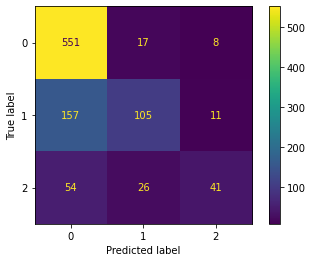

rf
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       576
           1       0.69      0.39      0.50       273
           2       0.68      0.34      0.45       121

    accuracy                           0.72       970
   macro avg       0.70      0.56      0.59       970
weighted avg       0.71      0.72      0.68       970



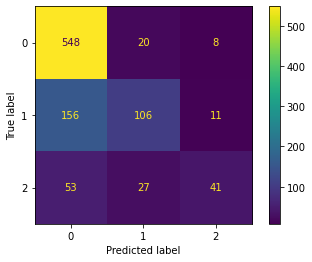

knc
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       576
           1       0.57      0.29      0.39       273
           2       0.49      0.22      0.31       121

    accuracy                           0.67       970
   macro avg       0.58      0.48      0.50       970
weighted avg       0.63      0.67      0.62       970



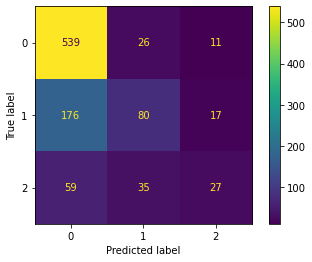

svc
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       576
           1       0.75      0.34      0.47       273
           2       0.71      0.31      0.43       121

    accuracy                           0.71       970
   macro avg       0.72      0.54      0.57       970
weighted avg       0.72      0.71      0.67       970



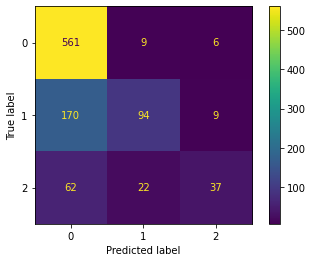

xgb
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       576
           1       0.71      0.52      0.60       273
           2       0.69      0.49      0.57       121

    accuracy                           0.75       970
   macro avg       0.72      0.64      0.67       970
weighted avg       0.75      0.75      0.74       970



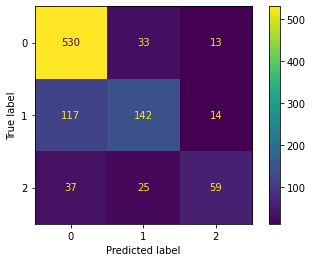

cat
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       576
           1       0.73      0.46      0.56       273
           2       0.73      0.49      0.58       121

    accuracy                           0.75       970
   macro avg       0.74      0.63      0.66       970
weighted avg       0.74      0.75      0.73       970



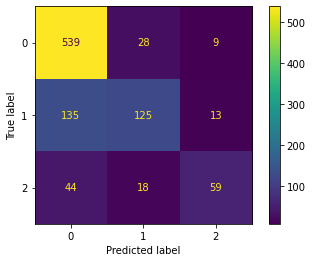

extra
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       576
           1       0.72      0.46      0.56       273
           2       0.71      0.40      0.51       121

    accuracy                           0.74       970
   macro avg       0.72      0.60      0.63       970
weighted avg       0.74      0.74      0.72       970



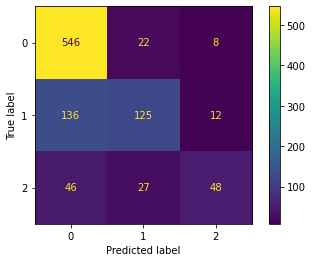

In [477]:
for name, model in trained_models.items():
    print(name)
    print(classification_report(y_test, model.predict(X_test)))
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()
    plt.show()

As we could see above, all of the models are strongly overfitting and dont generalize well so that the accuracy on the test set is roughly 20% less than on the train set. When we look at the confusion matrices there are no models which predicted more than 50% labels correctly for all 3 classes. Lets now look at the pipeline with stemmer.

## Standard ML models - stemming

There are 2 possible english language stemmers to choose from *nltk* package, here we use a *PorterStemmer*. Then we can write a function which preprocess every word in every review.

In [795]:
def stemming_process(X, stemmer=PorterStemmer()):
    words = [[stemmer.stem(c) for c in text.split()] for text in X]
    return [' '.join(i) for i in words]

In [63]:
stemming_process_tf = FunctionTransformer(stemming_process, kw_args={'stemmer':PorterStemmer()})

In [480]:
text_prep_pipeline = Pipeline([
    ('regex', apply_regex_tf),
    ('stopwords', stopwords_remover_tf),
    ('stemming', stemming_process_tf),
    ('vectorizer', TfidfVectorizer(stop_words=eng_stopwords))
])

In [481]:
X_prep = text_prep_pipeline.fit_transform(X)

In [482]:
X_prep

<4846x7596 sparse matrix of type '<class 'numpy.float64'>'
	with 59963 stored elements in Compressed Sparse Row format>

In [483]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, stratify=y, random_state=200)

In [484]:
models = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(n_jobs=-1),
    'knc': KNeighborsClassifier(n_jobs=-1),
    'svc': SVC(),
    'xgb': XGBClassifier(n_jobs=-1),
    'cat': CatBoostClassifier(),
    'extra': ExtraTreesClassifier(n_jobs=-1),
}

trained_models = {}

for name, algo in models.items():
    model = algo.fit(X_train, y_train)
    trained_models[name] = model

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.084787
0:	learn: 1.0637994	total: 90.1ms	remaining: 1m 30s
1:	learn: 1.0310513	total: 151ms	remaining: 1m 15s
2:	learn: 1.0043441	total: 213ms	remaining: 1m 10s
3:	learn: 0.9796640	total: 271ms	remaining: 1m 7s
4:	learn: 0.9588315	total: 330ms	remaining: 1m 5s
5:	learn: 0.9399501	total: 394ms	remaining: 1m 5s
6:	learn: 0.9238794	total: 456ms	remaining: 1m 4s
7:	learn: 0.9087674	total: 518ms	remaining: 1m 4s
8:	learn: 0.8965223	total: 581ms	remaining: 1m 3s
9:	learn: 0.8858574	total: 639ms	remaining: 1m 3s
10:	learn: 0.8749567	total: 696ms	remaining: 1m 2s
11:	learn: 0.8662289	total: 754ms	remaining: 1m 2s
12:	learn: 0.8570982	total: 812ms	remaining: 1m 1s
13

156:	learn: 0.6301217	total: 9.45s	remaining: 50.7s
157:	learn: 0.6295944	total: 9.5s	remaining: 50.7s
158:	learn: 0.6291185	total: 9.57s	remaining: 50.6s
159:	learn: 0.6286448	total: 9.64s	remaining: 50.6s
160:	learn: 0.6280866	total: 9.71s	remaining: 50.6s
161:	learn: 0.6272499	total: 9.77s	remaining: 50.6s
162:	learn: 0.6265202	total: 9.84s	remaining: 50.5s
163:	learn: 0.6257732	total: 9.9s	remaining: 50.5s
164:	learn: 0.6250404	total: 9.97s	remaining: 50.5s
165:	learn: 0.6245225	total: 10s	remaining: 50.4s
166:	learn: 0.6237776	total: 10.1s	remaining: 50.4s
167:	learn: 0.6232581	total: 10.2s	remaining: 50.4s
168:	learn: 0.6227451	total: 10.2s	remaining: 50.3s
169:	learn: 0.6222246	total: 10.3s	remaining: 50.2s
170:	learn: 0.6217418	total: 10.3s	remaining: 50.1s
171:	learn: 0.6211965	total: 10.4s	remaining: 50.1s
172:	learn: 0.6208558	total: 10.5s	remaining: 50s
173:	learn: 0.6203074	total: 10.5s	remaining: 50s
174:	learn: 0.6198173	total: 10.6s	remaining: 49.9s
175:	learn: 0.619052

315:	learn: 0.5604890	total: 19.3s	remaining: 41.9s
316:	learn: 0.5600743	total: 19.4s	remaining: 41.8s
317:	learn: 0.5598695	total: 19.5s	remaining: 41.7s
318:	learn: 0.5596852	total: 19.5s	remaining: 41.7s
319:	learn: 0.5594458	total: 19.6s	remaining: 41.6s
320:	learn: 0.5592811	total: 19.6s	remaining: 41.5s
321:	learn: 0.5590207	total: 19.7s	remaining: 41.5s
322:	learn: 0.5588483	total: 19.8s	remaining: 41.4s
323:	learn: 0.5584511	total: 19.8s	remaining: 41.4s
324:	learn: 0.5579041	total: 19.9s	remaining: 41.3s
325:	learn: 0.5576938	total: 19.9s	remaining: 41.2s
326:	learn: 0.5574245	total: 20s	remaining: 41.2s
327:	learn: 0.5571698	total: 20.1s	remaining: 41.1s
328:	learn: 0.5564878	total: 20.1s	remaining: 41s
329:	learn: 0.5561850	total: 20.2s	remaining: 41s
330:	learn: 0.5558211	total: 20.2s	remaining: 40.9s
331:	learn: 0.5555113	total: 20.3s	remaining: 40.8s
332:	learn: 0.5553361	total: 20.4s	remaining: 40.8s
333:	learn: 0.5550144	total: 20.4s	remaining: 40.7s
334:	learn: 0.5547

476:	learn: 0.5220752	total: 29.5s	remaining: 32.4s
477:	learn: 0.5219303	total: 29.6s	remaining: 32.3s
478:	learn: 0.5217876	total: 29.7s	remaining: 32.3s
479:	learn: 0.5214213	total: 29.7s	remaining: 32.2s
480:	learn: 0.5212611	total: 29.8s	remaining: 32.2s
481:	learn: 0.5208391	total: 29.9s	remaining: 32.1s
482:	learn: 0.5204956	total: 30s	remaining: 32.1s
483:	learn: 0.5204162	total: 30s	remaining: 32s
484:	learn: 0.5202797	total: 30.1s	remaining: 31.9s
485:	learn: 0.5201186	total: 30.1s	remaining: 31.9s
486:	learn: 0.5200014	total: 30.2s	remaining: 31.9s
487:	learn: 0.5198857	total: 30.3s	remaining: 31.8s
488:	learn: 0.5196145	total: 30.4s	remaining: 31.7s
489:	learn: 0.5194815	total: 30.4s	remaining: 31.7s
490:	learn: 0.5193425	total: 30.5s	remaining: 31.6s
491:	learn: 0.5191808	total: 30.6s	remaining: 31.6s
492:	learn: 0.5190037	total: 30.6s	remaining: 31.5s
493:	learn: 0.5188454	total: 30.7s	remaining: 31.4s
494:	learn: 0.5183639	total: 30.8s	remaining: 31.4s
495:	learn: 0.5181

635:	learn: 0.4925851	total: 39.2s	remaining: 22.5s
636:	learn: 0.4924468	total: 39.3s	remaining: 22.4s
637:	learn: 0.4923593	total: 39.4s	remaining: 22.3s
638:	learn: 0.4915400	total: 39.4s	remaining: 22.3s
639:	learn: 0.4912709	total: 39.5s	remaining: 22.2s
640:	learn: 0.4911741	total: 39.5s	remaining: 22.1s
641:	learn: 0.4910553	total: 39.6s	remaining: 22.1s
642:	learn: 0.4909264	total: 39.6s	remaining: 22s
643:	learn: 0.4906809	total: 39.7s	remaining: 21.9s
644:	learn: 0.4903908	total: 39.8s	remaining: 21.9s
645:	learn: 0.4902900	total: 39.8s	remaining: 21.8s
646:	learn: 0.4901110	total: 39.9s	remaining: 21.7s
647:	learn: 0.4899436	total: 39.9s	remaining: 21.7s
648:	learn: 0.4898815	total: 40s	remaining: 21.6s
649:	learn: 0.4897376	total: 40s	remaining: 21.6s
650:	learn: 0.4895259	total: 40.1s	remaining: 21.5s
651:	learn: 0.4891987	total: 40.1s	remaining: 21.4s
652:	learn: 0.4891286	total: 40.2s	remaining: 21.4s
653:	learn: 0.4889469	total: 40.3s	remaining: 21.3s
654:	learn: 0.4888

797:	learn: 0.4670612	total: 48.4s	remaining: 12.3s
798:	learn: 0.4667983	total: 48.5s	remaining: 12.2s
799:	learn: 0.4667229	total: 48.5s	remaining: 12.1s
800:	learn: 0.4664116	total: 48.6s	remaining: 12.1s
801:	learn: 0.4663478	total: 48.6s	remaining: 12s
802:	learn: 0.4662451	total: 48.7s	remaining: 11.9s
803:	learn: 0.4661583	total: 48.8s	remaining: 11.9s
804:	learn: 0.4660811	total: 48.8s	remaining: 11.8s
805:	learn: 0.4659671	total: 48.9s	remaining: 11.8s
806:	learn: 0.4658504	total: 48.9s	remaining: 11.7s
807:	learn: 0.4657528	total: 49s	remaining: 11.6s
808:	learn: 0.4656378	total: 49s	remaining: 11.6s
809:	learn: 0.4655281	total: 49.1s	remaining: 11.5s
810:	learn: 0.4654300	total: 49.2s	remaining: 11.5s
811:	learn: 0.4653716	total: 49.3s	remaining: 11.4s
812:	learn: 0.4652029	total: 49.4s	remaining: 11.4s
813:	learn: 0.4650881	total: 49.4s	remaining: 11.3s
814:	learn: 0.4648629	total: 49.5s	remaining: 11.2s
815:	learn: 0.4647592	total: 49.6s	remaining: 11.2s
816:	learn: 0.4646

957:	learn: 0.4473798	total: 57.9s	remaining: 2.54s
958:	learn: 0.4471187	total: 58s	remaining: 2.48s
959:	learn: 0.4470729	total: 58s	remaining: 2.42s
960:	learn: 0.4469737	total: 58.1s	remaining: 2.36s
961:	learn: 0.4467159	total: 58.2s	remaining: 2.3s
962:	learn: 0.4466350	total: 58.2s	remaining: 2.24s
963:	learn: 0.4465536	total: 58.3s	remaining: 2.18s
964:	learn: 0.4464103	total: 58.4s	remaining: 2.12s
965:	learn: 0.4463658	total: 58.4s	remaining: 2.06s
966:	learn: 0.4462768	total: 58.5s	remaining: 2s
967:	learn: 0.4461486	total: 58.5s	remaining: 1.93s
968:	learn: 0.4459690	total: 58.6s	remaining: 1.87s
969:	learn: 0.4458726	total: 58.7s	remaining: 1.81s
970:	learn: 0.4456561	total: 58.7s	remaining: 1.75s
971:	learn: 0.4455362	total: 58.8s	remaining: 1.69s
972:	learn: 0.4453899	total: 58.8s	remaining: 1.63s
973:	learn: 0.4453157	total: 58.9s	remaining: 1.57s
974:	learn: 0.4452452	total: 58.9s	remaining: 1.51s
975:	learn: 0.4451516	total: 59s	remaining: 1.45s
976:	learn: 0.4450365	

In [485]:
for name, model in trained_models.items():
    print(name, round(100 * accuracy_score(y_train, model.predict(X_train)), 2))

lr 85.47
rf 99.92
knc 77.53
svc 96.18
xgb 91.9
cat 84.24
extra 99.92


In [486]:
for name, model in trained_models.items():
    print(name, round(100 * accuracy_score(y_test, model.predict(X_test)), 2))

lr 71.75
rf 71.65
knc 65.88
svc 70.72
xgb 75.88
cat 73.81
extra 73.09


lr
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       576
           1       0.71      0.39      0.50       273
           2       0.67      0.34      0.45       121

    accuracy                           0.72       970
   macro avg       0.70      0.56      0.59       970
weighted avg       0.71      0.72      0.69       970



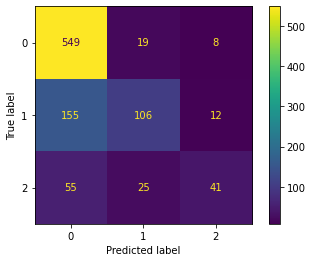

rf
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       576
           1       0.68      0.39      0.50       273
           2       0.74      0.36      0.48       121

    accuracy                           0.72       970
   macro avg       0.72      0.56      0.60       970
weighted avg       0.71      0.72      0.69       970



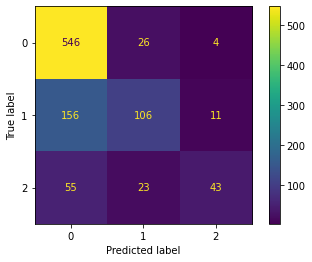

knc
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       576
           1       0.55      0.28      0.37       273
           2       0.47      0.18      0.26       121

    accuracy                           0.66       970
   macro avg       0.57      0.47      0.48       970
weighted avg       0.62      0.66      0.61       970



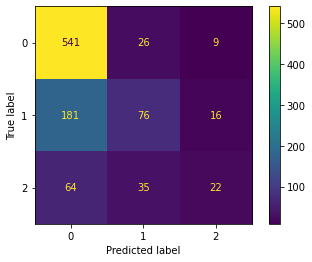

svc
              precision    recall  f1-score   support

           0       0.70      0.97      0.82       576
           1       0.74      0.32      0.45       273
           2       0.69      0.31      0.43       121

    accuracy                           0.71       970
   macro avg       0.71      0.54      0.56       970
weighted avg       0.71      0.71      0.66       970



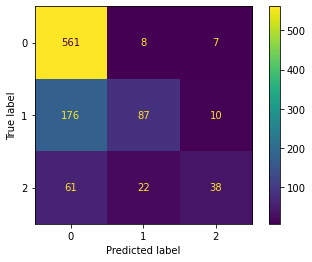

xgb
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       576
           1       0.72      0.54      0.62       273
           2       0.68      0.47      0.56       121

    accuracy                           0.76       970
   macro avg       0.73      0.65      0.67       970
weighted avg       0.75      0.76      0.75       970



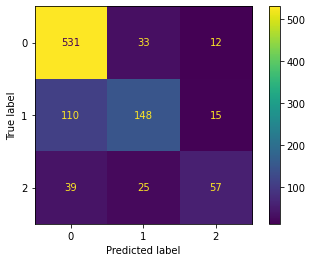

cat
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       576
           1       0.73      0.47      0.57       273
           2       0.68      0.45      0.54       121

    accuracy                           0.74       970
   macro avg       0.72      0.61      0.65       970
weighted avg       0.73      0.74      0.72       970



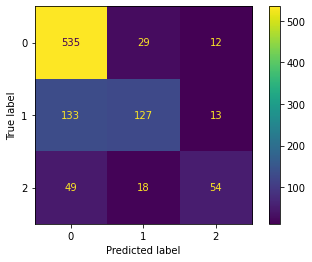

extra
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       576
           1       0.69      0.45      0.55       273
           2       0.73      0.36      0.48       121

    accuracy                           0.73       970
   macro avg       0.72      0.58      0.62       970
weighted avg       0.73      0.73      0.71       970



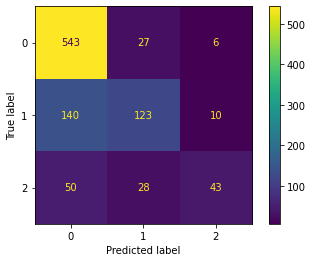

In [487]:
for name, model in trained_models.items():
    print(name)
    print(classification_report(y_test, model.predict(X_test)))
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()
    plt.show()

There is almost no difference whether we use stemming or lemmatization and all models are overfitting again. Lets now move to the RNNs and see if they can solve the problem.

## RNN

Here we are going to build a simple RNN model with an embedding layer. To do this, first we have to vectorize each review. It can be done with a *TextVectorization* layer which creates a vocabulary from a text corpus and encode every review as a list of indices for each word in the vocabulary. The length of each sequence is the same and we can specify it manually. Then every shorter sequence is just padded with zeros which can be masked during training. We have to also specify the size of the vocabulary. 

In [64]:
text_prep_pipeline_stemmer = Pipeline([
    ('regex', apply_regex_tf),
    ('stopwords', stopwords_remover_tf),
    ('stemming', stemming_process_tf),
])

In [65]:
X_prep = text_prep_pipeline_stemmer.fit_transform(X)

In [67]:
pickle.dump(text_prep_pipeline_stemmer, open('prep_pipe.pkl', 'wb'))

In [853]:
max_vocabulary_size = 1000
max_len = 100

text_vectorization = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_vocabulary_size,
                                       output_mode='int', output_sequence_length=max_len)
text_vectorization.adapt(X_prep)

In [854]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(text_vectorization)

In [855]:
X_prep = [[comment] for comment in X_prep]

In [856]:
X_prep_vect = model.predict(X_prep)

In [857]:
X_prep_vect.shape

(4846, 100)

In [858]:
X_prep_vect[0]

array([ 72,   1,   4,  86, 407,  22, 118,   1,   4, 446,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)

In [837]:
model.save('vectorizer', save_format='tf')

INFO:tensorflow:Assets written to: vectorizer\assets


In [733]:
X_train, X_test, y_train, y_test = train_test_split(X_prep_vect, y, stratify=y, test_size=0.2, random_state=200)

To speed up training we can also create a tensorflow dataset from encoded features and labels.

In [734]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(32).prefetch(1)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(1)

In [768]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('sentiment_model.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

embed_size = 20
model = keras.models.Sequential([  
    keras.layers.Embedding(max_vocabulary_size, embed_size, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [769]:
model.summary()

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, None, 20)          20000     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 64)                13568     
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 195       
Total params: 33,763
Trainable params: 33,763
Non-trainable params: 0
_________________________________________________________________


In [770]:
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=[checkpoint_cb, early_stopping])

Epoch 1/20
122/122 [==============================] - 12s 45ms/step - loss: 0.9759 - accuracy: 0.5900 - val_loss: 0.7829 - val_accuracy: 0.6515
Epoch 2/20
122/122 [==============================] - 4s 30ms/step - loss: 0.7420 - accuracy: 0.6717 - val_loss: 0.7193 - val_accuracy: 0.6856
Epoch 3/20
122/122 [==============================] - 3s 28ms/step - loss: 0.5975 - accuracy: 0.7414 - val_loss: 0.6771 - val_accuracy: 0.7093
Epoch 4/20
122/122 [==============================] - 3s 28ms/step - loss: 0.4985 - accuracy: 0.8118 - val_loss: 0.6572 - val_accuracy: 0.7361
Epoch 5/20
122/122 [==============================] - 3s 27ms/step - loss: 0.4272 - accuracy: 0.8411 - val_loss: 0.6835 - val_accuracy: 0.7443
Epoch 6/20
122/122 [==============================] - 3s 27ms/step - loss: 0.3634 - accuracy: 0.8628 - val_loss: 0.6823 - val_accuracy: 0.7485
Epoch 7/20
122/122 [==============================] - 3s 28ms/step - loss: 0.3324 - accuracy: 0.8823 - val_loss: 0.7222 - val_accuracy: 0.742

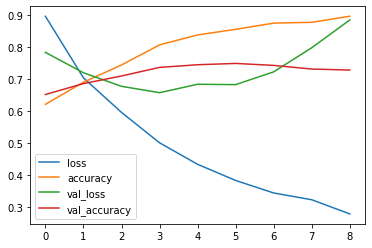

In [771]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       576
           1       0.63      0.59      0.61       273
           2       0.60      0.54      0.57       121

    accuracy                           0.74       970
   macro avg       0.68      0.66      0.67       970
weighted avg       0.73      0.74      0.73       970



Text(24.0, 0.5, 'True')

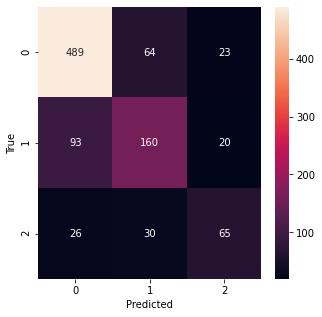

In [772]:
model = keras.models.load_model('sentiment_model.h5')

print(classification_report(y_test, np.argmax(model.predict(X_test), axis=-1)))
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=-1)), annot=True, fmt='g', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2303
           1       0.78      0.79      0.79      1090
           2       0.80      0.73      0.76       483

    accuracy                           0.85      3876
   macro avg       0.83      0.81      0.82      3876
weighted avg       0.85      0.85      0.85      3876



Text(24.0, 0.5, 'True')

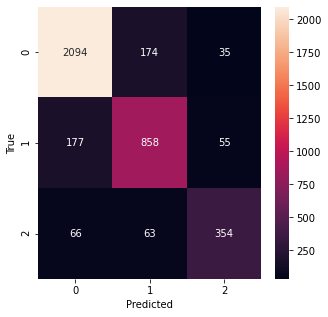

In [773]:
print(classification_report(y_train, np.argmax(model.predict(X_train), axis=-1)))
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_train, np.argmax(model.predict(X_train), axis=-1)), annot=True, fmt='g', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')

Here we can see the same problem as before. Our model is highly overfitting. For couple of steps the validation loss is decreasing but then it starts to increase. We use a early stopping and a model checkpoint callbacks to save the best model. We can either have a model which will perform well on the majority class and poor on the other or it will perform similar on all of them but still not really good. The model which was just trained is the overall best model in terms of validation loss where the minority classes have more correct predictions then we got with the previous models. The overfitting here is not that severe -> roughly *81%* accuracy on the train set and *74%* on the validation set. Now we can also try to train the other model for longer and compare predictions.

In [774]:
embed_size = 20
model = keras.models.Sequential([  
    keras.layers.Embedding(max_vocabulary_size, embed_size, mask_zero=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [775]:
model.summary()

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, None, 20)          20000     
_________________________________________________________________
lstm_82 (LSTM)               (None, 32)                6784      
_________________________________________________________________
dense_63 (Dense)             (None, 3)                 99        
Total params: 26,883
Trainable params: 26,883
Non-trainable params: 0
_________________________________________________________________


In [776]:
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)

Epoch 1/50
122/122 [==============================] - 8s 39ms/step - loss: 0.9898 - accuracy: 0.5900 - val_loss: 0.8044 - val_accuracy: 0.6402
Epoch 2/50
122/122 [==============================] - 3s 28ms/step - loss: 0.7688 - accuracy: 0.6595 - val_loss: 0.7550 - val_accuracy: 0.6680
Epoch 3/50
122/122 [==============================] - 3s 29ms/step - loss: 0.6364 - accuracy: 0.7276 - val_loss: 0.7120 - val_accuracy: 0.6948
Epoch 4/50
122/122 [==============================] - 4s 29ms/step - loss: 0.5725 - accuracy: 0.7545 - val_loss: 0.6967 - val_accuracy: 0.7072
Epoch 5/50
122/122 [==============================] - 4s 29ms/step - loss: 0.4720 - accuracy: 0.8183 - val_loss: 0.7067 - val_accuracy: 0.7289
Epoch 6/50
122/122 [==============================] - 4s 29ms/step - loss: 0.4125 - accuracy: 0.8541 - val_loss: 0.6859 - val_accuracy: 0.7351
Epoch 7/50
122/122 [==============================] - 4s 29ms/step - loss: 0.3674 - accuracy: 0.8667 - val_loss: 0.6922 - val_accuracy: 0.7247

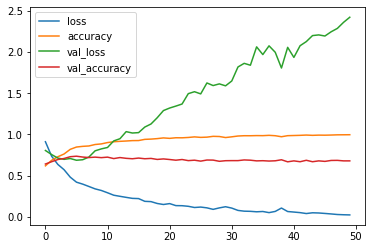

In [777]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       576
           1       0.56      0.55      0.55       273
           2       0.49      0.47      0.48       121

    accuracy                           0.68       970
   macro avg       0.61      0.60      0.60       970
weighted avg       0.68      0.68      0.68       970



Text(24.0, 0.5, 'True')

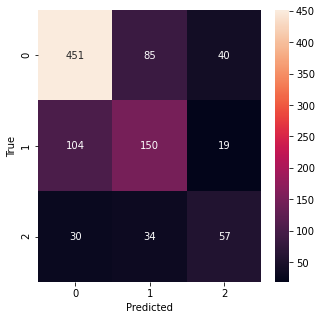

In [778]:
print(classification_report(y_test, np.argmax(model.predict(X_test), axis=-1)))
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=-1)), annot=True, fmt='g', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2303
           1       1.00      1.00      1.00      1090
           2       1.00      0.99      0.99       483

    accuracy                           1.00      3876
   macro avg       1.00      0.99      1.00      3876
weighted avg       1.00      1.00      1.00      3876



Text(24.0, 0.5, 'True')

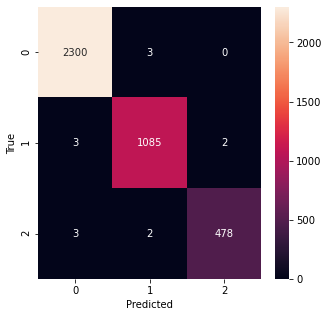

In [779]:
print(classification_report(y_train, np.argmax(model.predict(X_train), axis=-1)))
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_train, np.argmax(model.predict(X_train), axis=-1)), annot=True, fmt='g', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')

We could see that training for longer results in complete overfitting and we get exactly the same problem. Therefore we choose the previous RNN model as the best one and we gonna use it to build a simple app which will predict the class based on the review or comment written by the user. Before we do this lets also check here how we can make predictions on a single sentence.

In [901]:
sample = 'We could recently see an increase in the revenue of the X company from 20 millions USD to 50 millions USD.' 
sample_1 = 'Recently there was no changes in stock prices and they remained stable for a long period of time on the level of 50 million USD.'
sample_2  = 'Stock prices are decreasing by 20 dollars every day and it is not a good sign for them!'

In [888]:
model = keras.models.load_model('sentiment_model.h5')

In [889]:
vectorizer_model = keras.models.load_model('vectorizer')
vectorizer = vectorizer_model.layers[0]

In [890]:
prep_pipe = pickle.load(open('prep_pipe.pkl', 'rb'))

In [911]:
classes_map_inverse = {0: 'neutral', 1: 'positive', 2: 'negative'}

In [912]:
for i in [sample, sample_1, sample_2]:
    sample_prep = prep_pipe.transform([i])
    sample_prep = vectorizer(sample_prep)
    yhat = np.argmax(model.predict(sample_prep), axis=-1)[0]
    print(classes_map_inverse[yhat])

positive
neutral
negative
